In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob, os
import pandas as pd

base_dir = "/content/drive/Shareddrives/STA Project/dataset/dataset"

screen_files = glob.glob(
    os.path.join(base_dir, "**", "survey/**"),
    recursive=True
)

print(screen_files)
# load CSV
df = pd.read_csv('/content/drive/Shareddrives/STA Project/dataset/dataset/survey/BigFive.csv')

# print first 5 rows
print(df.head())

['/content/drive/Shareddrives/STA Project/dataset/dataset/survey/', '/content/drive/Shareddrives/STA Project/dataset/dataset/survey/BigFive.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/survey/FlourishingScale.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/survey/LonelinessScale.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/survey/PHQ-9.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/survey/panas.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/survey/PerceivedStressScale.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/survey/vr_12.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/survey/psqi.csv']
   uid type I see myself as someone who...   - 1. Is talkative  \
0  u00  pre                                     Agree a little   
1  u01  pre                         Neither agree nor disagree   
2  u02  pre                                  Disagree a little   
3  u03  pre            

Cleaning and converting text to scores

In [ ]:
import pandas as pd

# 1. Load the raw PHQ-9 file
phq = pd.read_csv("/content/drive/Shareddrives/STA Project/dataset/dataset/survey/PHQ-9.csv")

# 2. Define mapping from text → numeric score
phq_map = {
    "Not at all": 0,
    "Several days": 1,
    "More than half the days": 2,
    "Nearly every day": 3
}

# 3. Identify the 9 PHQ item columns
item_cols = [c for c in phq.columns if c not in ["uid", "type", "Response"]]

# 4. Convert each item to numeric using the mapping
for c in item_cols:
    phq[c + "_num"] = phq[c].map(phq_map)

# (Optional sanity check: no missing numeric values)
for c in item_cols:
    print(c, phq[c + "_num"].isna().sum())

# 5. Compute total PHQ-9 score (0–27)
num_cols = [c + "_num" for c in item_cols]
phq["phq9_score"] = phq[num_cols].sum(axis=1)

# 6. Create a binary depression label (standard cutoff: 10+)
phq["depressed"] = (phq["phq9_score"] >= 10).astype(int)

# 7. Keep a clean label table
labels_phq9 = phq[["uid", "type", "phq9_score", "depressed", "Response"]].copy()
labels_phq9 = labels_phq9.rename(columns={
    "uid": "user_id",
    "type": "label_time"  # pre / post
})

print(labels_phq9.head())

# 8. Save for later use
labels_phq9.to_csv("labels_phq9.csv", index=False)

Little interest or pleasure in doing things 0
Feeling down, depressed, hopeless. 0
Trouble falling or staying asleep, or sleeping too much. 0
Feeling tired or having little energy 0
Poor appetite or overeating 0
Feeling bad about yourself or that you are a failure or have let yourself or your family down 0
Trouble concentrating on things, such as reading the newspaper or watching television 0
Moving or speaking so slowly that other people could have noticed. Or the opposite being so figety or restless that you have been moving around a lot more than usual 0
Thoughts that you would be better off dead, or of hurting yourself 0
  user_id label_time  phq9_score  depressed              Response
0     u00        pre           2          0  Not difficult at all
1     u01        pre           5          0        Very difficult
2     u02        pre          13          1    Somewhat difficult
3     u03        pre           2          0    Somewhat difficult
4     u04        pre           6     

In [ ]:
import pandas as pd

# 1. Load the raw PSS file
pss = pd.read_csv("/content/drive/Shareddrives/STA Project/dataset/dataset/survey/PerceivedStressScale.csv")

# 2. Basic cleaning: drop exact duplicate rows (if any)
pss = pss.drop_duplicates()

# 3. Define mapping from text → numeric score (for non-reversed items)
pss_map = {
    "Never": 0,
    "Almost never": 1,
    "Sometime": 2,
    "Fairly often": 3,
    "Very often": 4
}

# 4. Identify item columns (everything except uid and type)
item_cols = [c for c in pss.columns if c not in ["uid", "type"]]

# 5. Map text responses to numbers
for c in item_cols:
    pss[c + "_num"] = pss[c].map(pss_map)

# Optional: check for any unmapped / missing values
for c in item_cols:
    n_missing = pss[c + "_num"].isna().sum()
    print(f"{c}: {n_missing} missing numeric values")

# If you see any missing due to weird typos, you can fix them before scoring.

# 6. Define which items are reversed (PSS-10 standard)
# Items 4,5,7,8 are reverse-scored
reverse_item_nums = [4, 5, 7, 8]
reverse_item_cols = [c for c in item_cols
                     if any(c.strip().startswith(f"{i}.") for i in reverse_item_nums)]

normal_item_cols = [c for c in item_cols if c not in reverse_item_cols]

print("Normal items:", normal_item_cols)
print("Reverse-scored items:", reverse_item_cols)

# 7. Reverse score the positive items: new_score = 4 - old_score
for c in reverse_item_cols:
    num_col = c + "_num"
    pss[num_col] = 4 - pss[num_col]

# 8. Compute total PSS score (sum of all 10 numeric items)
num_cols = [c + "_num" for c in item_cols]
pss["pss_score"] = pss[num_cols].sum(axis=1)

# 9. Keep a clean label table
labels_pss = pss[["uid", "type", "pss_score"]].copy()
labels_pss = labels_pss.rename(columns={
    "uid": "user_id",
    "type": "label_time"  # pre/post if applicable
})

print(labels_pss.head())

# 10. Save cleaned PSS labels
labels_pss.to_csv("labels_pss.csv", index=False)

1. In the last month, how often have you been upset because of something that happened unexpectedly?: 0 missing numeric values
2. In the last month, how often have you felt that you were unable to control the important things in your life?: 0 missing numeric values
3. In the last month, how often have you felt nervous and "stressed"?: 1 missing numeric values
4. In the last month, how often have you felt confident about your ability to handle your personal problems?: 0 missing numeric values
5. In the last month, how often have you felt that things were going your way?: 1 missing numeric values
6. In the last month, how often have you found that you could not cope with all the things that you had to do?: 0 missing numeric values
7. In the last month, how often have you been able to control irritations in your life?: 0 missing numeric values
8. In the last month, how often have you felt that you were on top of things?: 0 missing numeric values
9. In the last month, how often have you be

In [ ]:
import pandas as pd

psqi = pd.read_csv("/content/drive/Shareddrives/STA Project/dataset/dataset/survey/psqi.csv")

for col in psqi.columns:
    print(f"\nCOLUMN: {col}")
    print(psqi[col].unique()[:10])


COLUMN: uid
['u00' 'u01' 'u02' 'u03' 'u04' 'u05' 'u07' 'u08' 'u09' 'u10']

COLUMN: type
['pre' 'post']

COLUMN: During the past month, what time have you usually gone to bed at night? 
['2:00 AM' '1AM' 'around 1 am' '1am' '11:30' '11:30pm'
 'Between 12a and 2a' '1:00 AM' '12:00' '12-1 AM']

COLUMN: During the past month, how long (in minutes) has it usually taken you to fall asleep each night?
['10 mins' '20' 'I fall asleep really quickly, maybe 5-10minutes' '10min'
 '10' '15' '20 minutes' '15 minutes' '30' '<10 mins']

COLUMN: When have you usually gotten up in the morning?
['7:00 AM' '11AM' 'about 9am' '8:30am' '6:00' '8:00am'
 'between 9a and 11a' '9:00 AM' '8:30' '8:10 AM']

COLUMN: During the past month, how many hours of actual sleep did you get at night? (This may be different than the number of hours you spent in bed.)
['6 hours' '10-Sep' 'about 7-8hours' '7hours' '6:00' '8' '7 Hours' '7.5'
 '8-Jul' '7']

COLUMN: a. Cannot get to sleep within 30 minutes
['Not during the past m

In [ ]:
import pandas as pd
import numpy as np

# 1. Load PSQI file
psqi = pd.read_csv("/content/drive/Shareddrives/STA Project/dataset/dataset/survey/psqi.csv")

# 2. Drop exact duplicate rows (if any)
psqi = psqi.drop_duplicates()

# 3. Define mappings

freq_map = {
    "Not during the past month": 0,
    "Less than once week": 1,
    "Once or a twice week": 2,
    "Three or a more times week": 3
}

sleep_quality_map = {
    "Very good": 0,
    "Fairly good": 1,
    "Fairly bad": 2,
    "Very bad": 3
}

# 4. Identify the disturbance & frequency columns (a–j + 3 frequency questions)

disturb_cols = [
    'a. Cannot get to sleep within 30 minutes',
    'b. Wake up in the middle of the night or early morning',
    'c. Have to get up to use the bathroom',
    'd. Cannot breathe comfortably',
    'e. Cough or snore loudly',
    'f. Feel too cold',
    'g. Feel too hot',
    'h. Have bad dreams',
    'i. Have pain',
    'j. Other reason(s)'
]

freq_extra_cols = [
    'During the past month, how often have you taken medicine (prescribed or over the counter) to help you sleep?',
    'During the past month, how often have you had trouble staying awake while driving, eating meals, or engaging in social activity?',
    'During the past month, how much of a problem has it been for you to keep up enthusiasm to get things done?'
]

sleep_quality_col = 'During the past month, how would you rate your sleep quality overall?'

# 5. Map disturbance + frequency columns to numeric

for c in disturb_cols + freq_extra_cols:
    if c in psqi.columns:
        psqi[c + "_num"] = psqi[c].map(freq_map)

# 6. Map overall sleep quality to numeric

psqi["sleep_quality_num"] = psqi[sleep_quality_col].map(sleep_quality_map)

# 7. Create a simple disturbance score: mean of all disturbance items (a–j)

disturb_num_cols = [c + "_num" for c in disturb_cols if c + "_num" in psqi.columns]
psqi["sleep_disturbance_score"] = psqi[disturb_num_cols].mean(axis=1, skipna=True)

# 8. Create a simple daytime dysfunction score: mean of the extra frequency cols

extra_num_cols = [c + "_num" for c in freq_extra_cols if c + "_num" in psqi.columns]
psqi["daytime_dysfunction_score"] = psqi[extra_num_cols].mean(axis=1, skipna=True)

# 9. Combine into one overall sleep score (simple proxy, not official global PSQI)
# You can change the formula if you like.
psqi["psqi_sleep_score"] = (
    psqi["sleep_quality_num"]
    + psqi["sleep_disturbance_score"].fillna(0)
    + psqi["daytime_dysfunction_score"].fillna(0)
)

# 10. Build a clean label table

labels_psqi = psqi[["uid", "type", "psqi_sleep_score", "sleep_quality_num",
                    "sleep_disturbance_score", "daytime_dysfunction_score"]].copy()

labels_psqi = labels_psqi.rename(columns={
    "uid": "user_id",
    "type": "label_time"  # pre/post
})

print(labels_psqi.head())

# 11. Save cleaned PSQI labels

labels_psqi.to_csv("labels_psqi.csv", index=False)

  user_id label_time  psqi_sleep_score  sleep_quality_num  \
0     u00        pre          3.566667                2.0   
1     u01        pre          2.466667                0.0   
2     u02        pre          2.433333                1.0   
3     u03        pre          1.766667                1.0   
4     u04        pre          2.000000                1.0   

   sleep_disturbance_score  daytime_dysfunction_score  
0                 0.900000                   0.666667  
1                 0.800000                   1.666667  
2                 0.100000                   1.333333  
3                 0.100000                   0.666667  
4                 0.333333                   0.666667  


In [ ]:
import pandas as pd
import numpy as np
import glob
import os

# -----------------------------
# CONFIG: update this path
# -----------------------------
BASE_DIR = "/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/phonelock"

# -----------------------------
# Helper: extract user_id from filename
# Example: phonelock_u00.csv → u00
# -----------------------------
def get_user_id(filepath):
    filename = os.path.basename(filepath)
    # find "_uXX" in the filename
    start = filename.find("_u")
    if start != -1:
        return filename[start+1:start+4]  # e.g., "u00"
    return None

# -----------------------------
# Process ALL phonelock files
# -----------------------------
all_files = glob.glob(os.path.join(BASE_DIR, "*.csv"))
print("Found phonelock files:", all_files)

frames = []

for f in all_files:
    user_id = get_user_id(f)
    if user_id is None:
        continue

    df = pd.read_csv(f)

    # Drop rows with missing timestamps
    df = df.dropna(subset=["start", "end"])

    # Convert UNIX timestamps → datetime
    df["start_dt"] = pd.to_datetime(df["start"], unit="s", errors="coerce")
    df["end_dt"]   = pd.to_datetime(df["end"], unit="s", errors="coerce")

    # Drop invalid rows
    df = df.dropna(subset=["start_dt", "end_dt"])

    # Compute duration in minutes
    df["duration_min"] = (df["end_dt"] - df["start_dt"]).dt.total_seconds() / 60

    # Keep only positive intervals
    df = df[df["duration_min"] > 0]

    # Extract DATE only (no time)
    df["date"] = df["start_dt"].dt.date

    # Add user_id
    df["user_id"] = user_id

    frames.append(df)

# Combine all users
phonelock_raw = pd.concat(frames, ignore_index=True)
print("Raw combined phonelock shape:", phonelock_raw.shape)

# -----------------------------
# Daily aggregation
# -----------------------------
screen_time_daily = phonelock_raw.groupby(["user_id", "date"])["duration_min"].sum().reset_index()

# rename columns nicely
screen_time_daily = screen_time_daily.rename(columns={
    "duration_min": "daily_screen_time_min"
})

print(screen_time_daily.head())

# -----------------------------
# Save final phonelock features
# -----------------------------
screen_time_daily.to_csv("features_phonelock.csv", index=False)
print("Saved: features_phonelock.csv")

Found phonelock files: ['/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/phonelock/phonelock_u35.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/phonelock/phonelock_u41.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/phonelock/phonelock_u01.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/phonelock/phonelock_u57.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/phonelock/phonelock_u12.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/phonelock/phonelock_u17.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/phonelock/phonelock_u07.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/phonelock/phonelock_u23.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/phonelock/phonelock_u27.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/phonelock/phonelock_u34.csv', '/content/drive/Shareddriv

In [ ]:
import pandas as pd
import numpy as np
import glob
import os

# -----------------------------
# CONFIG: update your path here
# -----------------------------
BASE_DIR = "/content/drive/Shareddrives/STA Project/dataset/dataset/app_usage"

# -----------------------------
# Helper: extract user_id from filename
# Example: running_app_u00.csv → u00
# -----------------------------
def get_user_id(filepath):
    filename = os.path.basename(filepath)
    # handles cases like running_app_u00.csv, running_app_u10.csv
    parts = filename.split("_")
    for p in parts:
        if p.startswith("u"):
            return p[:3]   # u00, u01, etc.
    return None

# -----------------------------
# Process ALL running_app files
# -----------------------------
all_files = glob.glob(os.path.join(BASE_DIR, "*.csv"))
print("Found running_app files:", all_files)

frames = []

for f in all_files:
    user_id = get_user_id(f)
    if user_id is None:
        continue

    df = pd.read_csv(f)

    # Must contain timestamp column → fix name if needed
    timestamp_col = "timestamp" if "timestamp" in df.columns else df.columns[0]

    # Drop missing timestamps
    df = df.dropna(subset=[timestamp_col])

    # Convert timestamp → datetime
    df["ts_dt"] = pd.to_datetime(df[timestamp_col], unit="s", errors="coerce")
    df = df.dropna(subset=["ts_dt"])

    # Extract date
    df["date"] = df["ts_dt"].dt.date

    # Add user_id
    df["user_id"] = user_id

    frames.append(df)

# Combine all users
running_app_raw = pd.concat(frames, ignore_index=True)
print("Combined shape:", running_app_raw.shape)

# -----------------------------
# Daily aggregation
# -----------------------------

# Count total app events per day
app_events_daily = (
    running_app_raw.groupby(["user_id", "date"])
    .size()
    .reset_index(name="daily_app_events")
)

# Optional extra: count distinct apps per day
if "RUNNING_TASKS_mPackage" in running_app_raw.columns:
    app_unique_daily = (
        running_app_raw.groupby(["user_id", "date"])["RUNNING_TASKS_mPackage"]
        .nunique()
        .reset_index(name="daily_unique_apps")
    )
    app_events_daily = app_events_daily.merge(app_unique_daily,
                                              on=["user_id", "date"], how="left")

print(app_events_daily.head())

# -----------------------------
# Save final running_app features
# -----------------------------
app_events_daily.to_csv("features_running_app.csv", index=False)
print("Saved: features_running_app.csv")

Found running_app files: ['/content/drive/Shareddrives/STA Project/dataset/dataset/app_usage/running_app_u02.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/app_usage/running_app_u01.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/app_usage/running_app_u00.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/app_usage/running_app_u03.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/app_usage/running_app_u10.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/app_usage/running_app_u08.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/app_usage/running_app_u04.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/app_usage/running_app_u07.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/app_usage/running_app_u05.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/app_usage/running_app_u09.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/app_usage/running_app_u14.c

In [ ]:
import pandas as pd
import numpy as np
import glob
import os

# -----------------------------
# CONFIG: update this for your dataset
# -----------------------------
BASE_DIR = "/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/activity"

# -----------------------------
# Helper: extract user_id
# -----------------------------
def get_user_id(filepath):
    filename = os.path.basename(filepath)
    parts = filename.split("_")
    for p in parts:
        if p.startswith("u"):
            return p[:3]   # u00, u01, etc.
    return None

# -----------------------------
# Process ALL activity_uXX.csv files
# -----------------------------
all_files = glob.glob(os.path.join(BASE_DIR, "*.csv"))
print("Found activity files:", all_files)

frames = []

for f in all_files:
    user_id = get_user_id(f)
    if user_id is None:
        continue

    df = pd.read_csv(f)

    # Identify timestamp + activity columns
    timestamp_col = "timestamp" if "timestamp" in df.columns else df.columns[0]
    activity_col = "activity" if "activity" in df.columns else df.columns[1]

    # Drop missing timestamps
    df = df.dropna(subset=[timestamp_col])

    # Convert timestamp to datetime
    df["ts_dt"] = pd.to_datetime(df[timestamp_col], unit="s", errors="coerce")
    df = df.dropna(subset=["ts_dt"])

    # Extract date for grouping
    df["date"] = df["ts_dt"].dt.date

    # Add user_id
    df["user_id"] = user_id

    frames.append(df)

# Combine all users
activity_raw = pd.concat(frames, ignore_index=True)
print("Raw activity shape:", activity_raw.shape)

# -----------------------------
# Daily feature extraction
# -----------------------------

# Count minutes or samples per activity type (assuming sampling every X seconds)
activity_daily_counts = (
    activity_raw
    .groupby(["user_id", "date", activity_col])
    .size()
    .reset_index(name="count")
)

# Pivot to wide format
activity_daily_pivot = activity_daily_counts.pivot_table(
    index=["user_id", "date"],
    columns=activity_col,
    values="count",
    fill_value=0
).reset_index()

# Rename columns for clarity
rename_map = {
    0: "still_count",
    1: "walking_count",
    2: "running_count",
    3: "unknown_count"
}

activity_daily_pivot = activity_daily_pivot.rename(columns=rename_map)

# Compute activity ratios
activity_daily_pivot["active_count"] = (
    activity_daily_pivot.get("walking_count", 0)
    + activity_daily_pivot.get("running_count", 0)
)

activity_daily_pivot["sedentary_ratio"] = (
    activity_daily_pivot.get("still_count", 0)
    / (
        activity_daily_pivot.get("still_count", 0)
        + activity_daily_pivot.get("walking_count", 0)
        + activity_daily_pivot.get("running_count", 0)
        + 1e-6
    )
)

print(activity_daily_pivot.head())

# -----------------------------
# Save final activity features
# -----------------------------
activity_daily_pivot.to_csv("features_activity.csv", index=False)
print("Saved: features_activity.csv")

Found activity files: ['/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/activity/activity_u00.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/activity/activity_u01.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/activity/activity_u02.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/activity/activity_u03.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/activity/activity_u04.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/activity/activity_u05.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/activity/activity_u07.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/activity/activity_u08.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/activity/activity_u09.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/activity/activity_u10.csv', '/content/drive/Shareddrives/STA Project/datase

In [ ]:
import pandas as pd
import numpy as np
import glob
import os
from math import radians, cos, sin, asin, sqrt

BASE_DIR = "/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/gps"

def get_user_id(filepath):
    filename = os.path.basename(filepath)
    parts = filename.split("_")
    for p in parts:
        if p.startswith("u"):
            return p[:3]
    return None

# Haversine distance function
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371000  # meters
    return c * r

all_files = glob.glob(os.path.join(BASE_DIR, "*.csv"))
print("Found GPS files:", all_files)

frames = []

for f in all_files:
    user_id = get_user_id(f)
    if user_id is None:
        continue

    df = pd.read_csv(f)

    # --- FIX 1: handle timestamp correctly ---
    # If 'time' column is numeric-like, use it. Otherwise, use the index.
    if "time" in df.columns:
        time_numeric = pd.to_numeric(df["time"], errors="coerce")
        if time_numeric.notna().sum() > 0:
            ts = time_numeric
        else:
            ts = df.index.to_series()
    else:
        ts = df.index.to_series()

    df["ts_dt"] = pd.to_datetime(ts, unit="s", errors="coerce")
    df = df.dropna(subset=["ts_dt"])

    # Drop missing/invalid coords
    df = df.dropna(subset=["latitude", "longitude"])
    df = df[
        df["latitude"].between(-90, 90) &
        df["longitude"].between(-180, 180)
    ]

    if df.empty:
        continue

    df["date"] = df["ts_dt"].dt.date
    df["user_id"] = user_id

    frames.append(df)

if not frames:
    gps_raw = pd.DataFrame(columns=["user_id", "date", "latitude", "longitude"])
else:
    gps_raw = pd.concat(frames, ignore_index=True)

print("GPS raw shape:", gps_raw.shape)

# ----------------------------------------
# Daily aggregates (no apply + reset_index)
# ----------------------------------------
if gps_raw.empty:
    gps_features = pd.DataFrame(columns=[
        "user_id", "date", "gps_points", "lat_var", "lon_var", "max_distance_m"
    ])
else:
    # basic daily stats
    gps_daily = gps_raw.groupby(["user_id", "date"]).agg(
        gps_points=("latitude", "size"),
        lat_var=("latitude", "var"),
        lon_var=("longitude", "var")
    ).reset_index()

    # max distance per day
    def daily_max_distance(x):
        if len(x) < 2:
            return 0.0
        lats = x["latitude"].values
        lons = x["longitude"].values
        max_d = 0.0
        for i in range(len(x)):
            for j in range(i+1, len(x)):
                d = haversine(lons[i], lats[i], lons[j], lats[j])
                if d > max_d:
                    max_d = d
        return max_d

    gps_daily_dist = gps_raw.groupby(["user_id", "date"]).apply(
        daily_max_distance
    ).reset_index(name="max_distance_m")

    gps_features = gps_daily.merge(gps_daily_dist, on=["user_id", "date"], how="left")

gps_features.to_csv("features_gps.csv", index=False)
print("Saved: features_gps.csv")
print(gps_features.head())

Found GPS files: ['/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/gps/gps_u04.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/gps/gps_u03.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/gps/gps_u01.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/gps/gps_u02.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/gps/gps_u00.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/gps/gps_u09.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/gps/gps_u05.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/gps/gps_u07.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/gps/gps_u08.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/gps/gps_u10.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/gps/gps_u16.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/gps/

/tmp/ipython-input-674675568.py:104: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gps_daily_dist = gps_raw.groupby(["user_id", "date"]).apply(


In [ ]:
import pandas as pd
import numpy as np
import glob
import os
from math import radians, cos, sin, asin, sqrt

BASE_DIR = "/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/gps"

def get_user_id(filepath):
    filename = os.path.basename(filepath)
    parts = filename.split("_")
    for p in parts:
        if p.startswith("u"):
            return p[:3]
    return None

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371000
    return c * r

all_files = glob.glob(os.path.join(BASE_DIR, "*.csv"))
frames = []

for f in all_files:
    user_id = get_user_id(f)
    df = pd.read_csv(f)

    # convert 'time' from string to int
    df["time"] = pd.to_numeric(df["time"], errors="coerce")
    df = df.dropna(subset=["time"])

    # convert to datetime using seconds
    df["ts_dt"] = pd.to_datetime(df["time"], unit="s", errors="coerce")
    df = df.dropna(subset=["ts_dt"])

    # clean coordinates
    df = df.dropna(subset=["latitude", "longitude"])
    df = df[(df["latitude"].between(-90, 90)) & (df["longitude"].between(-180, 180))]

    if df.empty:
        continue

    df["date"] = df["ts_dt"].dt.date
    df["user_id"] = user_id
    frames.append(df)

if not frames:
    print("Still empty — but it should not be now.")
else:
    gps_raw = pd.concat(frames, ignore_index=True)
    print("GPS raw shape:", gps_raw.shape)

    # simple stats
    gps_daily = (
        gps_raw.groupby(["user_id", "date"], as_index=False)
        .agg(
            gps_points=("latitude", "size"),
            lat_var=("latitude", "var"),
            lon_var=("longitude", "var")
        )
    )

    # daily max distance
    def daily_max_distance(group):
        coords = group[["latitude", "longitude"]].to_numpy()
        if len(coords) < 2:
            return 0.0
        max_d = 0
        for i in range(len(coords)):
            for j in range(i+1, len(coords)):
                d = haversine(coords[i][1], coords[i][0],
                              coords[j][1], coords[j][0])
                max_d = max(max_d, d)
        return max_d

    gps_daily_dist = (
        gps_raw.groupby(["user_id", "date"], as_index=False)
        .apply(lambda g: pd.Series({"max_distance_m": daily_max_distance(g)}))
    )

    gps_features = gps_daily.merge(gps_daily_dist, on=["user_id", "date"])
    gps_features.to_csv("features_gps.csv", index=False)
    print("Saved: features_gps.csv")

Still empty — but it should not be now.


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/gps/gps_u04.csv", nrows=5)

print(df.head())
print(df.columns)
print(df.index)

               time provider  network_type   accuracy   latitude  longitude  \
1364357187  network     wifi          27.0  43.704217 -72.285881        0.0   
1364358387  network     wifi          33.0  43.704169 -72.285786        0.0   
1364359587  network     wifi          31.5  43.704192 -72.285832        0.0   
1364360787  network     wifi          25.0  43.704200 -72.285841        0.0   
1364361987  network     wifi          22.0  43.704196 -72.285842        0.0   

            altitude  bearing       speed  travelstate  
1364357187       0.0      0.0  stationary          NaN  
1364358387       0.0      0.0      moving          NaN  
1364359587       0.0      0.0  stationary          NaN  
1364360787       0.0      0.0  stationary          NaN  
1364361987       0.0      0.0      moving          NaN  
Index(['time', 'provider', 'network_type', 'accuracy', 'latitude', 'longitude',
       'altitude', 'bearing', 'speed', 'travelstate'],
      dtype='object')
Index([1364357187, 1364358

In [ ]:
import pandas as pd
import numpy as np
import glob
import os
from math import radians, cos, sin, asin, sqrt

BASE_DIR = "/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/gps"

def get_user_id(filepath):
    filename = os.path.basename(filepath)
    parts = filename.split("_")
    for p in parts:
        if p.startswith("u"):
            return p[:3]   # "u00", "u01", ...
    return None

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371000  # meters
    return c * r

all_files = glob.glob(os.path.join(BASE_DIR, "*.csv"))
print("Found GPS files:", all_files[:5])

frames = []

for f in all_files:
    user_id = get_user_id(f)
    if user_id is None:
        continue

    # IMPORTANT: use index_col=0 because the index stores the timestamp
    df = pd.read_csv(f, index_col=0)

    # index = time in seconds (as you showed)
    # convert index to numeric
    df.index = pd.to_numeric(df.index, errors="coerce")
    df = df[~df.index.isna()]  # drop rows where index couldn't be parsed

    # convert to datetime
    df["ts_dt"] = pd.to_datetime(df.index, unit="s", errors="coerce")
    df = df.dropna(subset=["ts_dt"])

    # clean coordinates
    df = df.dropna(subset=["latitude", "longitude"])
    df = df[(df["latitude"].between(-90, 90)) & (df["longitude"].between(-180, 180))]

    if df.empty:
        print("No valid GPS rows after cleaning in:", f)
        continue

    df["date"] = df["ts_dt"].dt.date
    df["user_id"] = user_id

    frames.append(df)

if not frames:
    print("No GPS rows survived cleaning – but *now* that would mean the data really is empty.")
else:
    gps_raw = pd.concat(frames, ignore_index=True)
    print("GPS raw shape:", gps_raw.shape)

    # ---- daily simple stats ----
    gps_daily = (
        gps_raw
        .groupby(["user_id", "date"], as_index=False)
        .agg(
            gps_points=("latitude", "size"),
            lat_var=("latitude", "var"),
            lon_var=("longitude", "var")
        )
    )

    # ---- daily max distance ----
    def daily_max_distance(group):
        coords = group[["latitude", "longitude"]].to_numpy()
        if len(coords) < 2:
            return 0.0
        max_d = 0.0
        for i in range(len(coords)):
            for j in range(i+1, len(coords)):
                d = haversine(coords[i][1], coords[i][0],
                              coords[j][1], coords[j][0])
                if d > max_d:
                    max_d = d
        return max_d

    gps_daily_dist = (
        gps_raw.groupby(["user_id", "date"], as_index=False)
        .apply(lambda g: pd.Series({"max_distance_m": daily_max_distance(g)}))
    )

    gps_features = gps_daily.merge(gps_daily_dist, on=["user_id", "date"], how="left")

    print(gps_features.head())

    gps_features.to_csv("features_gps.csv", index=False)
    print("Saved: features_gps.csv")

Found GPS files: ['/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/gps/gps_u04.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/gps/gps_u03.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/gps/gps_u01.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/gps/gps_u02.csv', '/content/drive/Shareddrives/STA Project/dataset/dataset/sensing/gps/gps_u00.csv']
GPS raw shape: (201161, 13)
  user_id        date  gps_points   lat_var      lon_var  max_distance_m
0     u00  2013-03-27          55  0.000846  1628.674092    3.951098e+06
1     u00  2013-03-28          66  0.002792   219.274102    3.414492e+06
2     u00  2013-03-29          61  0.000924   364.439538    3.805945e+06
3     u00  2013-03-30          40  0.000100     0.000000    4.454091e+03
4     u00  2013-03-31          69  0.000468     0.000000    1.858305e+04
Saved: features_gps.csv


/tmp/ipython-input-874889001.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({"max_distance_m": daily_max_distance(g)}))


In [ ]:
import pandas as pd

sample_call = pd.read_csv("/content/drive/Shareddrives/STA Project/dataset/dataset/call_log/call_log_u00.csv", nrows=5)
print(sample_call.head())
print(sample_call.columns)

                                        id  \
0  8b67cbb5-cfa2-465b-b5af-31ee2c6606a6-40   
1  9c0354e8-4f4f-451a-9358-efe17df0d26c-22   
2  9c0354e8-4f4f-451a-9358-efe17df0d26c-22   
3  9c0354e8-4f4f-451a-9358-efe17df0d26c-22   
4  9c0354e8-4f4f-451a-9358-efe17df0d26c-22   

                                 device   timestamp  CALLS__id    CALLS_date  \
0  1977b545-a88f-4903-a7ae-2c434de4be49  1364099483        NaN           NaN   
1  1977b545-a88f-4903-a7ae-2c434de4be49  1364077455      213.0  1.364077e+12   
2  1977b545-a88f-4903-a7ae-2c434de4be49  1364077455      212.0  1.364077e+12   
3  1977b545-a88f-4903-a7ae-2c434de4be49  1364077455      211.0  1.364075e+12   
4  1977b545-a88f-4903-a7ae-2c434de4be49  1364077455      210.0  1.364074e+12   

   CALLS_duration                                         CALLS_name  \
0             NaN                                                NaN   
1            10.0  {"ONE_WAY_HASH":"70f8bb9a8a5393ef080507a89e4b9...   
2            13.0  {"ONE_W

In [ ]:
sample_sms = pd.read_csv("/content/drive/Shareddrives/STA Project/dataset/dataset/sms/sms_u00.csv", nrows=5)
print(sample_sms.head())
print(sample_sms.columns)

                                        id  \
0  8b67cbb5-cfa2-465b-b5af-31ee2c6606a6-37   
1  9c0354e8-4f4f-451a-9358-efe17df0d26c-20   
2  9c0354e8-4f4f-451a-9358-efe17df0d26c-20   
3  9c0354e8-4f4f-451a-9358-efe17df0d26c-20   
4  9c0354e8-4f4f-451a-9358-efe17df0d26c-20   

                                 device   timestamp  \
0  1977b545-a88f-4903-a7ae-2c434de4be49  1364099482   
1  1977b545-a88f-4903-a7ae-2c434de4be49  1363969836   
2  1977b545-a88f-4903-a7ae-2c434de4be49  1363969836   
3  1977b545-a88f-4903-a7ae-2c434de4be49  1363969836   
4  1977b545-a88f-4903-a7ae-2c434de4be49  1363969836   

                                    MESSAGES_address  \
0                                                NaN   
1  {"ONE_WAY_HASH":"556038b6775eb7e9540eddc387db2...   
2  {"ONE_WAY_HASH":"fa21dd22145635c59be360a0d9ad1...   
3  {"ONE_WAY_HASH":"4ee0f234959253b2101d4cfcc9797...   
4  {"ONE_WAY_HASH":"4ee0f234959253b2101d4cfcc9797...   

                                       MESSAGES_body  M

In [ ]:
import pandas as pd
import numpy as np
import glob
import os

CALL_DIR = "/content/drive/Shareddrives/STA Project/dataset/dataset/call_log"

def get_user_id(filepath):
    filename = os.path.basename(filepath)
    parts = filename.split("_")
    for p in parts:
        if p.startswith("u"):
            return p[:3]
    return None

call_files = glob.glob(os.path.join(CALL_DIR, "*.csv"))
call_frames = []

for f in call_files:
    user_id = get_user_id(f)
    df = pd.read_csv(f)

    # Skip files that don't have the needed columns
    required_cols = {"timestamp", "CALLS_duration", "CALLS_type"}
    if not required_cols.issubset(df.columns):
        print("Skipping file (missing required columns):", f)
        print("Columns found:", df.columns.tolist())
        continue

    # Drop rows without timestamp
    df = df.dropna(subset=["timestamp"])

    # Convert timestamp to datetime
    df["ts_dt"] = pd.to_datetime(df["timestamp"], unit="s", errors="coerce")
    df = df.dropna(subset=["ts_dt"])

    # Extract date
    df["date"] = df["ts_dt"].dt.date
    df["user_id"] = user_id

    # Convert numeric fields
    df["CALLS_type"] = pd.to_numeric(df["CALLS_type"], errors="coerce")      # 1/2 etc.
    df["CALLS_duration"] = pd.to_numeric(df["CALLS_duration"], errors="coerce")

    call_frames.append(df)

if call_frames:
    call_raw = pd.concat(call_frames, ignore_index=True)
else:
    call_raw = pd.DataFrame(columns=["user_id", "date"])

call_daily = call_raw.groupby(["user_id", "date"]).agg(
    daily_call_count=("CALLS_type", "count"),
    incoming_call_count=("CALLS_type", lambda x: (x == 1).sum()),
    outgoing_call_count=("CALLS_type", lambda x: (x == 2).sum()),
    total_call_duration_sec=("CALLS_duration", "sum"),
    avg_call_duration=("CALLS_duration", "mean")
).reset_index()

Skipping file (missing required columns): /content/drive/Shareddrives/STA Project/dataset/dataset/call_log/call_log_u01.csv
Columns found: ['id', 'device', 'timestamp']
Skipping file (missing required columns): /content/drive/Shareddrives/STA Project/dataset/dataset/call_log/call_log_u04.csv
Columns found: ['id', 'device', 'timestamp']
Skipping file (missing required columns): /content/drive/Shareddrives/STA Project/dataset/dataset/call_log/call_log_u09.csv
Columns found: ['id', 'device', 'timestamp']
Skipping file (missing required columns): /content/drive/Shareddrives/STA Project/dataset/dataset/call_log/call_log_u07.csv
Columns found: ['id', 'device', 'timestamp']
Skipping file (missing required columns): /content/drive/Shareddrives/STA Project/dataset/dataset/call_log/call_log_u05.csv
Columns found: ['id', 'device', 'timestamp']
Skipping file (missing required columns): /content/drive/Shareddrives/STA Project/dataset/dataset/call_log/call_log_u03.csv
Columns found: ['id', 'device',

In [ ]:
import pandas as pd
import numpy as np
import glob
import os

CALL_DIR = "/content/drive/Shareddrives/STA Project/dataset/dataset/call_log"
SMS_DIR = "/content/drive/Shareddrives/STA Project/dataset/dataset/sms"

def get_user_id(filepath):
    filename = os.path.basename(filepath)
    parts = filename.split("_")
    for p in parts:
        if p.startswith("u"):
            return p[:3]
    return None

# ------------------------------------------------
# SAFE CALL LOG EXTRACTION
# ------------------------------------------------

call_files = glob.glob(os.path.join(CALL_DIR, "*.csv"))
call_frames = []

for f in call_files:
    user_id = get_user_id(f)
    df = pd.read_csv(f)

    if df.empty:
        continue

    # Ensure required columns exist
    for col in ["timestamp", "CALLS_type", "CALLS_duration"]:
        if col not in df.columns:
            df[col] = np.nan

    # timestamp → datetime
    df["ts_dt"] = pd.to_datetime(df["timestamp"], unit="s", errors="coerce")
    df["date"] = df["ts_dt"].dt.date

    df["user_id"] = user_id

    # numeric safe conversion
    df["CALLS_type"] = pd.to_numeric(df["CALLS_type"], errors="coerce")
    df["CALLS_duration"] = pd.to_numeric(df["CALLS_duration"], errors="coerce")

    call_frames.append(df)

# Build call daily summary (even if empty)
if call_frames:
    call_raw = pd.concat(call_frames, ignore_index=True)
    call_daily = call_raw.groupby(["user_id", "date"], as_index=False).agg(
        daily_call_count=("CALLS_type", "count"),
        incoming_call_count=("CALLS_type", lambda x: (x == 1).sum()),
        outgoing_call_count=("CALLS_type", lambda x: (x == 2).sum()),
        total_call_duration_sec=("CALLS_duration", "sum"),
        avg_call_duration=("CALLS_duration", "mean")
    )
else:
    call_daily = pd.DataFrame(columns=[
        "user_id", "date", "daily_call_count", "incoming_call_count",
        "outgoing_call_count", "total_call_duration_sec", "avg_call_duration"
    ])

# ------------------------------------------------
# SAFE SMS EXTRACTION
# ------------------------------------------------

sms_files = glob.glob(os.path.join(SMS_DIR, "*.csv"))
sms_frames = []

for f in sms_files:
    user_id = get_user_id(f)
    df = pd.read_csv(f)

    if df.empty:
        continue

    # Ensure required columns
    for col in ["timestamp", "MESSAGES_type"]:
        if col not in df.columns:
            df[col] = np.nan

    df["ts_dt"] = pd.to_datetime(df["timestamp"], unit="s", errors="coerce")
    df["date"] = df["ts_dt"].dt.date
    df["user_id"] = user_id

    df["MESSAGES_type"] = pd.to_numeric(df["MESSAGES_type"], errors="coerce")

    sms_frames.append(df)

if sms_frames:
    sms_raw = pd.concat(sms_frames, ignore_index=True)
    sms_daily = sms_raw.groupby(["user_id", "date"], as_index=False).agg(
        daily_sms_count=("MESSAGES_type", "count"),
        sms_received_count=("MESSAGES_type", lambda x: (x == 1).sum()),
        sms_sent_count=("MESSAGES_type", lambda x: (x == 2).sum())
    )
else:
    sms_daily = pd.DataFrame(columns=[
        "user_id", "date",
        "daily_sms_count", "sms_received_count", "sms_sent_count"
    ])

# ------------------------------------------------
# MERGE CALL + SMS SAFELY
# ------------------------------------------------

features_social = pd.merge(call_daily, sms_daily,
                           on=["user_id", "date"], how="outer")

# Fill NaN with zeros for all numeric fields
for col in features_social.columns:
    if col not in ["user_id", "date"]:
        features_social[col] = features_social[col].fillna(0)

print(features_social.head())

# ------------------------------------------------
# SAVE CSV
# ------------------------------------------------

features_social.to_csv("features_social.csv", index=False)
print("Saved: features_social.csv")

  user_id        date  daily_call_count  incoming_call_count  \
0     u00  2013-03-22               0.0                  0.0   
1     u00  2013-03-23             213.0                 46.0   
2     u00  2013-03-24               2.0                  2.0   
3     u00  2013-03-25               2.0                  1.0   
4     u00  2013-03-26               6.0                  2.0   

   outgoing_call_count  total_call_duration_sec  avg_call_duration  \
0                  0.0                      0.0           0.000000   
1                150.0                  22394.0         105.136150   
2                  0.0                     39.0          19.500000   
3                  1.0                    512.0         256.000000   
4                  3.0                    227.0          37.833333   

   daily_sms_count  sms_received_count  sms_sent_count  
0             56.0                28.0            28.0  
1              0.0                 0.0             0.0  
2              0.0     

In [ ]:
import pandas as pd
import numpy as np
from functools import reduce
from sklearn.model_selection import train_test_split

# ============================================================
# 1. LOAD LABEL TABLES
# ============================================================

labels_phq9 = pd.read_csv("labels_phq9.csv")     # user_id, label_time, phq9_score, depressed
labels_pss  = pd.read_csv("labels_pss.csv")      # user_id, label_time, pss_score
labels_psqi = pd.read_csv("labels_psqi.csv")     # user_id, label_time, psqi_score

# Merge labels on user_id + label_time
labels_master = labels_phq9.merge(
    labels_pss, on=["user_id", "label_time"], how="left"
).merge(
    labels_psqi, on=["user_id", "label_time"], how="left"
)

# Keep only "pre" (if needed)
labels_master = labels_master[labels_master["label_time"] == "pre"].copy()

labels_master.to_csv("labels_master.csv", index=False)
print("Saved labels_master.csv")


# ============================================================
# 2. LOAD FEATURE TABLES (daily)
# ============================================================

f_phone   = pd.read_csv("features_phonelock.csv")
f_app     = pd.read_csv("features_running_app.csv")
f_act     = pd.read_csv("features_activity.csv")
f_gps     = pd.read_csv("features_gps.csv")
f_social  = pd.read_csv("features_social.csv")

# ============================================================
# 3. AGGREGATE DAILY FEATURES → PER USER MEANS
# ============================================================

def agg_per_user(df, prefix):
    if df.empty:
        return pd.DataFrame(columns=["user_id"])
    numeric_cols = [c for c in df.columns if c not in ["user_id", "date"]]
    agg = df.groupby("user_id")[numeric_cols].mean().reset_index()
    agg = agg.rename(columns={c: f"{prefix}_{c}" for c in numeric_cols})
    return agg

user_phone   = agg_per_user(f_phone,   "phlock")
user_app     = agg_per_user(f_app,     "app")
user_act     = agg_per_user(f_act,     "act")
user_gps     = agg_per_user(f_gps,     "gps")
user_social  = agg_per_user(f_social,  "soc")

feature_tables = [user_phone, user_app, user_act, user_gps, user_social]

# Merge all feature tables safely
features_all = None
for t in feature_tables:
    if t is not None and not t.empty:
        features_all = t if features_all is None else features_all.merge(t, on="user_id", how="outer")

features_all = features_all.fillna(0)
features_all.to_csv("features_all.csv", index=False)
print("Saved features_all.csv")


# ============================================================
# 4. MERGE LABELS + FEATURES → FINAL DATASET
# ============================================================

final_dataset = labels_master.merge(features_all, on="user_id", how="left")
final_dataset = final_dataset.fillna(0)

final_dataset.to_csv("final_dataset.csv", index=False)
print("Saved final_dataset.csv")

print("Final dataset shape:", final_dataset.shape)


# ============================================================
# 5. TRAIN–TEST SPLIT (predicting 'depressed')
# ============================================================

df = final_dataset.copy()

# Remove rows without label
df = df.dropna(subset=["depressed"])

# Separate target
y = df["depressed"]

# Remove non-feature columns
drop_cols = ["user_id", "label_time", "phq9_score", "depressed"]
X = df.drop(columns=drop_cols)

# Fill remaining NaNs just in case
X = X.fillna(0)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Save train/test
train = X_train.copy()
train["depressed"] = y_train.values
train.to_csv("train.csv", index=False)

test = X_test.copy()
test["depressed"] = y_test.values
test.to_csv("test.csv", index=False)

print("Saved: train.csv and test.csv")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Saved labels_master.csv
Saved features_all.csv
Saved final_dataset.csv
Final dataset shape: (46, 30)
Saved: train.csv and test.csv
Train shape: (36, 27)
Test shape: (10, 27)


In [ ]:
import pandas as pd

# Load your existing daily feature csvs
phonelock = pd.read_csv("features_phonelock.csv")
app       = pd.read_csv("features_running_app.csv")
# activity  = pd.read_csv("features_activity.csv")
# gps       = pd.read_csv("features_gps.csv")
# social    = pd.read_csv("features_social.csv")


# Combine all user-date rows
all_dates = pd.concat([
    phonelock[["user_id", "date"]],
    app[["user_id", "date"]],
    # activity[["user_id", "date"]],
    # gps[["user_id", "date"]],
    # social[["user_id", "date"]],
], ignore_index=True)

# Remove duplicates
all_dates = all_dates.drop_duplicates()

# Count total unique days across dataset
total_days = all_dates["date"].nunique()

# Count days per user
days_per_user = all_dates.groupby("user_id")["date"].nunique()

# Optional: Get min/max date per user
date_ranges = all_dates.groupby("user_id")["date"].agg(["min", "max"])


print("--------------------------------------------------")
print("Total unique dates across all users:", total_days)
print("--------------------------------------------------")
print("Days per user:")
print(days_per_user)
print("--------------------------------------------------")
print("Date range per user:")
print(date_ranges)

--------------------------------------------------
Total unique dates across all users: 103
--------------------------------------------------
Days per user:
user_id
u00    84
u01    65
u02    70
u03    56
u04    61
u05    67
u07    53
u08    67
u09    72
u10    71
u12    72
u13    68
u14    67
u15    51
u16    67
u17    70
u18    61
u19    69
u20    53
u22    67
u23    61
u24    35
u25    52
u27    72
u30    68
u31    69
u32    68
u33    59
u34    49
u35    69
u36    79
u39    27
u41    56
u42    55
u43    61
u44    64
u45    55
u46    58
u47    54
u49    78
u50    48
u51    93
u52    74
u53    68
u54    49
u56    69
u57    71
u58    65
u59    77
Name: date, dtype: int64
--------------------------------------------------
Date range per user:
                min         max
user_id                        
u00      2013-03-24  2013-06-20
u01      2013-03-24  2013-05-29
u02      2013-03-24  2013-06-01
u03      2013-03-24  2013-05-22
u04      2013-03-24  2013-05-23
u05      2013-03-24  20

In [ ]:
import pandas as pd

# Load daily feature files
phonelock = pd.read_csv("features_phonelock.csv")
app       = pd.read_csv("features_running_app.csv")
activity  = pd.read_csv("features_activity.csv")
gps       = pd.read_csv("features_gps.csv")
social    = pd.read_csv("features_social.csv")

# Load labeled users
labels = pd.read_csv("labels_master.csv")  # contains user_id for labeled users

labeled_users = labels["user_id"].unique().tolist()
print("Labeled users:", labeled_users)

# Combine all user-day rows
all_dates = pd.concat([
    phonelock[["user_id", "date"]],
    app[["user_id", "date"]],
    activity[["user_id", "date"]],
    gps[["user_id", "date"]],
    social[["user_id", "date"]],
], ignore_index=True)

# Filter to only labeled users
labeled_dates = all_dates[all_dates["user_id"].isin(labeled_users)].drop_duplicates()

# Count days per labeled user
days_per_labeled_user = labeled_dates.groupby("user_id")["date"].nunique()

# Date ranges
date_ranges = labeled_dates.groupby("user_id")["date"].agg(["min", "max"])

print("--------------------------------------------------")
print("Days per labeled user:")
print(days_per_labeled_user)
print("--------------------------------------------------")
print("Date range per labeled user:")
print(date_ranges)
print("--------------------------------------------------")
print("Total labeled user-days:", len(labeled_dates))

Labeled users: ['u00', 'u01', 'u02', 'u03', 'u04', 'u05', 'u07', 'u08', 'u09', 'u10', 'u12', 'u13', 'u14', 'u15', 'u16', 'u17', 'u18', 'u19', 'u20', 'u22', 'u23', 'u24', 'u27', 'u30', 'u31', 'u32', 'u33', 'u34', 'u35', 'u36', 'u39', 'u42', 'u43', 'u44', 'u45', 'u46', 'u47', 'u49', 'u50', 'u51', 'u52', 'u53', 'u56', 'u57', 'u58', 'u59']
--------------------------------------------------
Days per labeled user:
user_id
u00    86
u01    65
u02    70
u03    56
u04    61
u05    67
u07    53
u08    68
u09    72
u10    71
u12    72
u13    69
u14    68
u15    51
u16    67
u17    70
u18    61
u19    69
u20    53
u22    67
u23    61
u24    35
u27    72
u30    68
u31    69
u32    70
u33    60
u34    54
u35    69
u36    79
u39    27
u42    55
u43    61
u44    64
u45    55
u46    58
u47    55
u49    78
u50    48
u51    94
u52    74
u53    68
u56    69
u57    72
u58    66
u59    77
Name: date, dtype: int64
--------------------------------------------------
Date range per labeled user:
               

In [ ]:
import pandas as pd
from functools import reduce

# =========================================
# 1. Load labels (PHQ-9, PSS, PSQI)
# =========================================
labels_master = pd.read_csv("labels_master.csv")

# If you only want "pre" labels (recommended):
if "label_time" in labels_master.columns:
    labels_master = labels_master[labels_master["label_time"] == "pre"].copy()

# Keep only labeled users we care about
labeled_users = labels_master["user_id"].unique().tolist()
print("Number of labeled users:", len(labeled_users))

# =========================================
# 2. Load daily feature tables
# =========================================
phonelock = pd.read_csv("features_phonelock.csv")     # user_id, date, ...
app       = pd.read_csv("features_running_app.csv")   # user_id, date, ...
activity  = pd.read_csv("features_activity.csv")      # user_id, date, ...
gps       = pd.read_csv("features_gps.csv")           # user_id, date, ...
social    = pd.read_csv("features_social.csv")        # user_id, date, ...

# Ensure 'date' is consistent (date type, not full datetime)
for df in [phonelock, app, activity, gps, social]:
    df["date"] = pd.to_datetime(df["date"]).dt.date

# =========================================
# 3. Merge all daily features on (user_id, date)
# =========================================
dfs = [phonelock, app, activity, gps, social]

# Start reducing with outer joins so we keep all available days
daily_features = reduce(
    lambda left, right: pd.merge(left, right, on=["user_id", "date"], how="outer"),
    dfs
)

print("Daily features shape BEFORE filtering to labeled users:", daily_features.shape)

# =========================================
# 4. Keep only labeled users
# =========================================
daily_features = daily_features[daily_features["user_id"].isin(labeled_users)].copy()
print("Daily features shape AFTER filtering to labeled users:", daily_features.shape)

# =========================================
# 5. Merge labels onto daily features
#    (labels are per user, repeated for all their days)
# =========================================
final_daily = pd.merge(
    daily_features,
    labels_master,
    on="user_id",
    how="left"
)

# Optionally drop rows where main label is missing
if "phq9_score" in final_daily.columns:
    final_daily = final_daily.dropna(subset=["phq9_score"])

# Sort nicely
final_daily = final_daily.sort_values(["user_id", "date"]).reset_index(drop=True)

print("Final daily dataset shape:", final_daily.shape)
print(final_daily.head())

# =========================================
# 6. Save to CSV
# =========================================
final_daily.to_csv("final_daily_dataset.csv", index=False)
print("Saved: final_daily_dataset.csv")

Number of labeled users: 46
Daily features shape BEFORE filtering to labeled users: (3134, 22)
Daily features shape AFTER filtering to labeled users: (2974, 22)
Final daily dataset shape: (2974, 31)
  user_id        date  daily_screen_time_min  daily_app_events  still_count  \
0     u00  2013-03-22                    NaN               NaN          NaN   
1     u00  2013-03-23                    NaN               NaN          NaN   
2     u00  2013-03-24                    NaN             472.0          NaN   
3     u00  2013-03-25                    NaN             630.0          NaN   
4     u00  2013-03-26                    NaN             737.0          NaN   

   walking_count  running_count  unknown_count  active_count  sedentary_ratio  \
0            NaN            NaN            NaN           NaN              NaN   
1            NaN            NaN            NaN           NaN              NaN   
2            NaN            NaN            NaN           NaN              NaN   
3 

PER USER PER DAY DATA

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ============================================
# 1. Load daily dataset
# ============================================
df = pd.read_csv("final_daily_dataset.csv")

print("Initial shape:", df.shape)

# ============================================
# 2. Select target label
# ============================================
# Most important label: depression from PHQ-9
y = df["depressed"]

# ============================================
# 3. Select feature columns
# Remove columns that should NOT be model inputs
# ============================================
drop_cols = [
    "user_id",    # identifier
    "date",       # time
    "label_time", # pre/post tag
    "depressed",  # target
    "phq9_score"  # raw score (should not be used to predict itself)
]

X = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Fill NA values just in case
X = X.fillna(0)

print("Feature matrix shape:", X.shape)

# ============================================
# 4. Train-test split (stratified to balance depressed/non-depressed)
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# ============================================
# 5. Save splits
# ============================================
train = X_train.copy()
train["depressed"] = y_train.values
train.to_csv("train_daily.csv", index=False)

test = X_test.copy()
test["depressed"] = y_test.values
test.to_csv("test_daily.csv", index=False)

print("Saved: train_daily.csv and test_daily.csv")

Initial shape: (2974, 31)
Feature matrix shape: (2974, 26)
Train size: (2081, 26)
Test size: (893, 26)
Saved: train_daily.csv and test_daily.csv


Model Building

In [ ]:
# model building

#load the preprocessed data
import pandas as pd

# Change the path to your true output location if needed
train = pd.read_csv('train_daily.csv')
test = pd.read_csv('test_daily.csv')

# Target: predicting 'depressed'
y_train = train['depressed']
X_train = train.drop(columns=['userid', 'labeltime', 'phq9score', 'depressed'], errors='ignore')
y_test = test['depressed']
X_test = test.drop(columns=['userid', 'labeltime', 'phq9score', 'depressed'], errors='ignore')


LASSO Regularized Regression

In [ ]:
print(X_train.dtypes[X_train.dtypes == 'object'])
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

Series([], dtype: object)
(2081, 26)
(893, 26)
(893,)


In [ ]:
print(X_train.shape)#one hot encoding
from sklearn.preprocessing import LabelEncoder

for col in X_train.columns:
    if X_train[col].dtype == 'object':
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))


(2081, 26)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Use L1 penalty for sparse feature selection (LASSO)
lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=5000)
lasso.fit(X_train, y_train)

# Predictions
y_pred = lasso.predict(X_test)
y_prob = lasso.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_prob))

# Show nonzero (selected) features
selected_features = X_train.columns[lasso.coef_[0] != 0]
print('Selected features:', selected_features.tolist())


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       736
           1       0.93      0.89      0.91       157

    accuracy                           0.97       893
   macro avg       0.95      0.94      0.95       893
weighted avg       0.97      0.97      0.97       893

ROC-AUC: 0.9800176543893658
Selected features: ['daily_screen_time_min', 'daily_app_events', 'still_count', 'walking_count', 'running_count', 'unknown_count', 'active_count', 'sedentary_ratio', 'gps_points', 'lat_var', 'lon_var', 'max_distance_m', 'daily_call_count', 'incoming_call_count', 'outgoing_call_count', 'total_call_duration_sec', 'avg_call_duration', 'daily_sms_count', 'sms_received_count', 'sms_sent_count', 'Response', 'pss_score', 'psqi_sleep_score', 'sleep_quality_num', 'sleep_disturbance_score', 'daytime_dysfunction_score']


Ridge Regression

In [ ]:
ridge = LogisticRegression(penalty='l2', solver='liblinear', max_iter=5000)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
y_prob_ridge = ridge.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_ridge))
print('ROC-AUC:', roc_auc_score(y_test, y_prob_ridge))


              precision    recall  f1-score   support

           0       0.83      0.91      0.87       736
           1       0.27      0.16      0.20       157

    accuracy                           0.78       893
   macro avg       0.55      0.53      0.53       893
weighted avg       0.74      0.78      0.75       893

ROC-AUC: 0.6959377596233731


In [ ]:
#Coefficient interpretation
# For LASSO
pd.Series(lasso.coef_[0], index=X_train.columns).sort_values(ascending=False).head(10)


,0
sleep_disturbance_score,2.245703
daytime_dysfunction_score,1.756097
pss_score,0.349882
sedentary_ratio,0.300859
psqi_sleep_score,0.203781
Response,0.096729
daily_call_count,0.065714
sms_sent_count,0.057465
daily_sms_count,0.013610
gps_points,0.009611


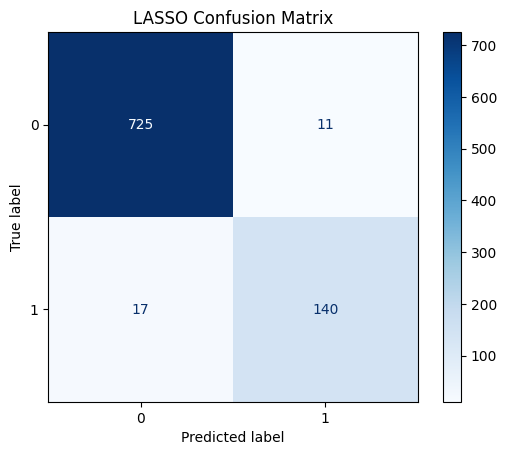

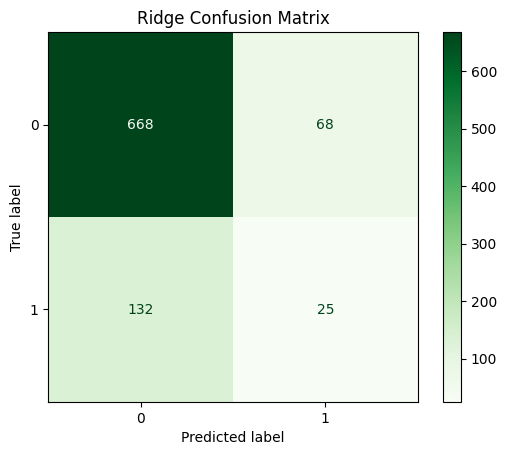

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

lasso_predictions = y_pred
ridge_predictions = y_pred_ridge

# LASSO Confusion Matrix
cm_lasso = confusion_matrix(y_test, lasso_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lasso)
disp.plot(cmap='Blues')
plt.title("LASSO Confusion Matrix")
plt.show()

# Ridge Confusion Matrix
cm_ridge = confusion_matrix(y_test, ridge_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ridge)
disp.plot(cmap='Greens')
plt.title("Ridge Confusion Matrix")
plt.show()

In [ ]:
feature_details = [
    {
        'Feature Name': 'daily_screen_time_min',
        'Category': 'Sensing Data',
        'Cleaning/Extraction Steps': 'Daily phone screen interaction duration (minutes).'
    },
    {
        'Feature Name': 'daily_app_events',
        'Category': 'Sensing Data',
        'Cleaning/Extraction Steps': 'Daily count of app usage events.'
    },
    {
        'Feature Name': 'still_count',
        'Category': 'Sensing Data',
        'Cleaning/Extraction Steps': 'Daily count of "still" activity events.'
    },
    {
        'Feature Name': 'walking_count',
        'Category': 'Sensing Data',
        'Cleaning/Extraction Steps': 'Daily count of "walking" activity events.'
    },
    {
        'Feature Name': 'running_count',
        'Category': 'Sensing Data',
        'Cleaning/Extraction Steps': 'Daily count of "running" activity events.'
    },
    {
        'Feature Name': 'unknown_count',
        'Category': 'Sensing Data',
        'Cleaning/Extraction Steps': 'Daily count of "unknown" activity events.'
    },
    {
        'Feature Name': 'active_count',
        'Category': 'Sensing Data',
        'Cleaning/Extraction Steps': 'Daily sum of walking and running events.'
    },
    {
        'Feature Name': 'sedentary_ratio',
        'Category': 'Sensing Data',
        'Cleaning/Extraction Steps': 'Daily ratio of "still" activity to total activities.'
    },
    {
        'Feature Name': 'gps_points',
        'Category': 'Sensing Data',
        'Cleaning/Extraction Steps': 'Daily count of GPS data points.'
    },
    {
        'Feature Name': 'lat_var',
        'Category': 'Sensing Data',
        'Cleaning/Extraction Steps': 'Daily variance of latitude coordinates.'
    },
    {
        'Feature Name': 'lon_var',
        'Category': 'Sensing Data',
        'Cleaning/Extraction Steps': 'Daily variance of longitude coordinates.'
    },
    {
        'Feature Name': 'max_distance_m',
        'Category': 'Sensing Data',
        'Cleaning/Extraction Steps': 'Daily maximum Haversine distance between any two GPS points (meters).'
    },
    {
        'Feature Name': 'daily_call_count',
        'Category': 'Sensing Data',
        'Cleaning/Extraction Steps': 'Daily total phone call count (incoming/outgoing).'
    },
    {
        'Feature Name': 'incoming_call_count',
        'Category': 'Sensing Data',
        'Cleaning/Extraction Steps': 'Daily count of incoming phone calls.'
    },
    {
        'Feature Name': 'outgoing_call_count',
        'Category': 'Sensing Data',
        'Cleaning/Extraction Steps': 'Daily count of outgoing phone calls.'
    },
    {
        'Feature Name': 'total_call_duration_sec',
        'Category': 'Sensing Data',
        'Cleaning/Extraction Steps': 'Daily total call duration (seconds).'
    },
    {
        'Feature Name': 'avg_call_duration',
        'Category': 'Sensing Data',
        'Cleaning/Extraction Steps': 'Daily average call duration (seconds).'
    },
    {
        'Feature Name': 'daily_sms_count',
        'Category': 'Sensing Data',
        'Cleaning/Extraction Steps': 'Daily total SMS message count (sent/received).'
    },
    {
        'Feature Name': 'sms_received_count',
        'Category': 'Sensing Data',
        'Cleaning/Extraction Steps': 'Daily count of received SMS messages.'
    },
    {
        'Feature Name': 'sms_sent_count',
        'Category': 'Sensing Data',
        'Cleaning/Extraction Steps': 'Daily count of sent SMS messages.'
    },
    {
        'Feature Name': 'Response',
        'Category': 'Survey',
        'Cleaning/Extraction Steps': 'Categorical response from PHQ-9 item.'
    },
    {
        'Feature Name': 'pss_score',
        'Category': 'Survey',
        'Cleaning/Extraction Steps': 'Perceived Stress Scale (PSS-10) total score.'
    },
    {
        'Feature Name': 'psqi_sleep_score',
        'Category': 'Survey',
        'Cleaning/Extraction Steps': 'Pittsburgh Sleep Quality Index (PSQI) composite score.'
    },
    {
        'Feature Name': 'sleep_quality_num',
        'Category': 'Survey',
        'Cleaning/Extraction Steps': 'Self-rated overall sleep quality (0-3) from PSQI.'
    },
    {
        'Feature Name': 'sleep_disturbance_score',
        'Category': 'Survey',
        'Cleaning/Extraction Steps': 'Mean sleep disturbance score (0-3) from PSQI.'
    },
    {
        'Feature Name': 'daytime_dysfunction_score',
        'Category': 'Survey',
        'Cleaning/Extraction Steps': 'Mean daytime dysfunction score (0-3) from PSQI.'
    }
]

latex_table = []
latex_table.append('\\begin{table*}[ht]')
latex_table.append('\\centering')
latex_table.append('\\caption{Summary of Features Used in Depression Prediction Model}')
latex_table.append('\\label{tab:features_summary}')
latex_table.append('\\begin{tabular}{|l|l|l|p{10cm}|}') # Added 'l' for enumeration column
latex_table.append('\\hline')
latex_table.append('\\textbf{No.} & \\textbf{Feature Name} & \\textbf{Category} & \\textbf{Description} \\\\') # Added 'No.' header
latex_table.append('\\hline')

enum_counter = 1 # Initialize counter
for feature in feature_details:
    feature_name = feature['Feature Name'].replace('_', '\\_')
    category = feature['Category']
    description = feature['Cleaning/Extraction Steps'].replace('%', '\\%').replace('&', '\\&')
    # Added enum_counter to the row
    latex_table.append(f"{enum_counter} & {feature_name} & {category} & {description} \\\\")
    latex_table.append('\\hline')
    enum_counter += 1 # Increment counter

latex_table.append('\\end{tabular}')
latex_table.append('\\end{table*}')

for line in latex_table:
    print(line)

\begin{table*}[ht]
\centering
\caption{Summary of Features Used in Depression Prediction Model}
\label{tab:features_summary}
\begin{tabular}{|l|l|l|p{10cm}|}
\hline
\textbf{No.} & \textbf{Feature Name} & \textbf{Category} & \textbf{Description} \\
\hline
1 & daily\_screen\_time\_min & Sensing Data & Daily phone screen interaction duration (minutes). \\
\hline
2 & daily\_app\_events & Sensing Data & Daily count of app usage events. \\
\hline
3 & still\_count & Sensing Data & Daily count of "still" activity events. \\
\hline
4 & walking\_count & Sensing Data & Daily count of "walking" activity events. \\
\hline
5 & running\_count & Sensing Data & Daily count of "running" activity events. \\
\hline
6 & unknown\_count & Sensing Data & Daily count of "unknown" activity events. \\
\hline
7 & active\_count & Sensing Data & Daily sum of walking and running events. \\
\hline
8 & sedentary\_ratio & Sensing Data & Daily ratio of "still" activity to total activities. \\
\hline
9 & gps\_points & Se